In [1]:
# Import các thư viện cần thiết
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import VGG19, ResNet152V2, Xception, DenseNet201
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from keras.layers import BatchNormalization, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import plot_model

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')
tf.config.optimizer.set_jit(True)

warnings.filterwarnings("ignore")

2025-09-04 06:28:50.367682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756967330.632689      99 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756967330.709478      99 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
try:
    # Ưu tiên dùng GPU (L4x4 hoặc A100 trên Kaggle)
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        strategy = tf.distribute.MirroredStrategy()  # Dùng nhiều GPU nếu có
        print(f"Using {len(gpus)} GPU(s)")
    else:
        # Nếu không có GPU thì fallback về CPU
        strategy = tf.distribute.get_strategy()
        print("No GPU found, using CPU")
except:
    strategy = tf.distribute.get_strategy()
    print("Fallback: Using default strategy (CPU)")
    
print("Number of accelerators:", strategy.num_replicas_in_sync)


Using 4 GPU(s)
Number of accelerators: 4


I0000 00:00:1756967345.057342      99 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21087 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9
I0000 00:00:1756967345.057938      99 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21087 MB memory:  -> device: 1, name: NVIDIA L4, pci bus id: 0000:00:04.0, compute capability: 8.9
I0000 00:00:1756967345.058426      99 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21087 MB memory:  -> device: 2, name: NVIDIA L4, pci bus id: 0000:00:05.0, compute capability: 8.9
I0000 00:00:1756967345.058925      99 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21087 MB memory:  -> device: 3, name: NVIDIA L4, pci bus id: 0000:00:06.0, compute capability: 8.9


In [3]:
directory = "/kaggle/input/chest-xray-covid19-pneumonia/Data/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)
# Head 
df_train

,filepath,label
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
...,...,...
5139,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
5140,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
5141,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
5142,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19


In [4]:
directory = "/kaggle/input/chest-xray-covid19-pneumonia/Data/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)
    
    imgs = os.listdir(f_path)
    
    for img in imgs:
        
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)
        
#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)
df_test

,filepath,label
0,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
1,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
2,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
3,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
4,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,PNEUMONIA
...,...,...
1283,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
1284,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
1285,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19
1286,/kaggle/input/chest-xray-covid19-pneumonia/Dat...,COVID19


In [5]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5144, 2)
The shape of The Test data is: (1288, 2)


In [6]:
data_dir = '/kaggle/input/chest-xray-covid19-pneumonia/Data/train'
test_dir = '/kaggle/input/chest-xray-covid19-pneumonia/Data/test'

In [7]:
# ===== MERGED CELL (FIXED): BiT-M Cluster-Stratified + X-ray Augmentation =====
import os, gc, numpy as np, pandas as pd, tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import ks_2samp

# ---- defaults nếu thiếu ----
IMAGE_SIZE   = globals().get('IMAGE_SIZE', (256, 256))
BATCH_SIZE   = int(globals().get('BATCH_SIZE', 32))
SEED         = int(globals().get('SEED', 42))

np.random.seed(SEED); tf.random.set_seed(SEED)
IMG_H, IMG_W = int(IMAGE_SIZE[0]), int(IMAGE_SIZE[1])
BS = int(BATCH_SIZE)

# ---- 0) quét ảnh từ train và test để kết hợp thành bộ chung ----
def _gather(root):
    items = []
    for dp, _, files in os.walk(root):
        if os.path.basename(dp).startswith('.'):
            continue
        for f in files:
            fl = f.lower()
            if fl.endswith(('.jpg','.jpeg','.png','.bmp','.webp')):
                fp = os.path.join(dp, f)
                label = os.path.basename(os.path.dirname(fp))
                items.append((os.path.abspath(fp), str(label)))
    return items

if 'data_dir' not in globals() or not os.path.isdir(data_dir):
    raise RuntimeError("Thiếu data_dir hoặc không hợp lệ.")
train_items = _gather(data_dir)
test_items = _gather(test_dir) if 'test_dir' in globals() and os.path.isdir(test_dir) else []
all_items = train_items + test_items
if not all_items:
    raise RuntimeError("Không tìm thấy ảnh dưới data_dir hoặc test_dir")
df_train_all = pd.DataFrame(all_items, columns=['filepath','label']).drop_duplicates('filepath').reset_index(drop=True)

# [MC] Hỗ trợ đa lớp: KHÔNG lọc cứng 2 lớp nữa. Cho phép lọc tùy chọn qua ALLOWED_LABELS nếu người dùng muốn.
ALLOWED_LABELS = globals().get('ALLOWED_LABELS', None)
if ALLOWED_LABELS is not None and len(ALLOWED_LABELS) > 0:
    _allowed = set(map(str, ALLOWED_LABELS))
    df_train_all = df_train_all[df_train_all['label'].astype(str).isin(_allowed)].reset_index(drop=True)
if df_train_all.empty:
    raise RuntimeError("Không còn ảnh sau khi áp dụng ALLOWED_LABELS (nếu có).")

# ---- 1) trích đặc trưng bằng BiT-M (ResNet50x1 TF-Hub) để CLUSTERING ----
def _load_and_prep(fp):
    img = tf.io.read_file(fp)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_H, IMG_W))
    img = tf.keras.applications.resnet.preprocess_input(tf.cast(img, tf.float32))
    return img

batch_embed = min(64, BS if BS > 0 else 32)
feat_ds = (tf.data.Dataset.from_tensor_slices(df_train_all['filepath'].values)
           .map(_load_and_prep, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_embed)
           .prefetch(tf.data.AUTOTUNE))

import tensorflow_hub as hub
bit_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_model = hub.KerasLayer(bit_url, trainable=False)

emb_list = []
with tf.device('/CPU:0'):
    for batch in feat_ds:
        emb_list.append(bit_model(batch, training=False).numpy())
emb = np.concatenate(emb_list, axis=0)

# ---- 2) PCA + KMeans -> nhãn cụm ----
pca = PCA(n_components=5, random_state=SEED)
Z5 = pca.fit_transform(emb)
kmeans = KMeans(n_clusters=4, n_init=10, random_state=SEED)
clusters = kmeans.fit_predict(Z5)
df_train_all = df_train_all.copy()
df_train_all['cluster'] = clusters

# ---- 3) stratified split 80/10/10 theo cụm và nhãn ----
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
tr_idx, temp_idx = next(sss.split(df_train_all, df_train_all['cluster']))
train_df = df_train_all.iloc[tr_idx].drop(columns=['cluster']).reset_index(drop=True)
temp_df = df_train_all.iloc[temp_idx].drop(columns=['cluster']).reset_index(drop=True)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=SEED)
va_idx, te_idx = next(sss.split(temp_df, temp_df['label']))
val_df = temp_df.iloc[va_idx].reset_index(drop=True)
test_df = temp_df.iloc[te_idx].reset_index(drop=True)

# Kiểm tra phân bố nhãn
print("Train labels:", train_df['label'].value_counts(normalize=True))
print("Val labels:",   val_df['label'].value_counts(normalize=True))
print("Test labels:",  test_df['label'].value_counts(normalize=True))

# ---- 4) KS test ----
# [MC] Sửa chỉ số để so cùng không gian Z5: va_idx/te_idx lấy từ temp_df nên cần map về chỉ số gốc.
tr_idx0 = tr_idx
va_idx0 = temp_idx[va_idx]
te_idx0 = temp_idx[te_idx]

ks_stats, p_vals = [], []
for j in range(Z5.shape[1]):
    ks, p = ks_2samp(Z5[tr_idx0, j], Z5[va_idx0, j])
    ks_stats.append(ks); p_vals.append(p)
print(f"[KS] mean KS = {np.mean(ks_stats):.4f} | mean p-value = {np.mean(p_vals):.4f}")
print(f"[Sizes] train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# ---- 5) Augmentation chuyên biệt cho ảnh X-quang (Albumentations) ----
try:
    import albumentations as A
    from albumentations.core.composition import OneOf
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "albumentations", "opencv-python-headless"])
    import albumentations as A
    from albumentations.core.composition import OneOf

import cv2

train_transform = A.Compose([
    A.Rotate(limit=15, border_mode=cv2.BORDER_REPLICATE, p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0,
                       border_mode=cv2.BORDER_REPLICATE, p=0.8),
    A.Affine(shear=0.1, p=0.5),
    A.HorizontalFlip(p=0.5),
    OneOf([
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    ], p=0.8),
    OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=0.5),
        A.GaussNoise(var_limit=(5, 20), p=0.5),
        A.MedianBlur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.Resize(IMG_H, IMG_W),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])

val_test_transform = A.Compose([
    A.Resize(IMG_H, IMG_W),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])

# ---- 6) Generator tương thích Keras: có .classes & .class_indices ----
class AlbumentationsGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, transform, class_names=None, batch_size=32, shuffle=True):
        self.df = df.reset_index(drop=True)
        if class_names is None:
            class_names = sorted(self.df['label'].astype(str).unique().tolist())
        self.class_names = list(class_names)
        self.class_indices = {c:i for i,c in enumerate(self.class_names)}
        self.classes = self.df['label'].astype(str).map(self.class_indices).values.astype(int)
        self.transform = transform
        self.batch_size = int(batch_size)
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    def __getitem__(self, index):
        idx = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        imgs, labels = [], []
        for i in idx:
            row = self.df.iloc[i]
            img = cv2.imread(row['filepath'])
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            aug = self.transform(image=img)
            img = aug['image'].astype(np.float32)
            imgs.append(img)
            labels.append(self.class_indices[str(row['label'])])
        if len(imgs) == 0:
            return np.zeros((0, IMG_H, IMG_W, 3), dtype=np.float32), np.zeros((0,), dtype=np.int32)
        return np.stack(imgs, axis=0), np.array(labels)
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# đồng bộ class_names giữa train/val/(test)
_all_names = pd.concat([
    train_df['label'].astype(str),
    val_df['label'].astype(str),
    test_df['label'].astype(str) if test_df is not None else pd.Series(dtype=str)
]).unique().tolist()
class_names = sorted(_all_names)

train_ds = AlbumentationsGenerator(train_df, train_transform, class_names=class_names, batch_size=BS, shuffle=True)
validation_ds = AlbumentationsGenerator(val_df, val_test_transform, class_names=class_names, batch_size=BS, shuffle=False)
test_ds = AlbumentationsGenerator(test_df, val_test_transform, class_names=class_names, batch_size=BS, shuffle=False) if test_df is not None else None

# alias để giữ tương thích
train_datagen = train_ds
validation_datagen = validation_ds
test_datagen = test_ds

# ---- 7) Nếu pipeline sau cần numpy arrays ----
def _to_numpy(seq):
    Xs, Ys = [], []
    for b in range(len(seq)):
        x, y = seq[b]
        if x.shape[0] == 0:  # batch rỗng
            continue
        Xs.append(x); Ys.append(y)
    if len(Xs) == 0:
        return np.zeros((0, IMG_H, IMG_W, 3), dtype=np.float32), np.zeros((0,), dtype=np.int32)
    return np.concatenate(Xs, axis=0), np.concatenate(Ys, axis=0)

x_train, y_train = _to_numpy(train_ds)
x_val,   y_val   = _to_numpy(validation_ds)
if test_ds is not None:
    x_test,  y_test  = _to_numpy(test_ds)
else:
    x_test = np.zeros((0, IMG_H, IMG_W, 3), dtype=np.float32)
    y_test = np.zeros((0,), dtype=np.int32)

x_train = x_train.astype(np.float32)
x_val   = x_val.astype(np.float32)
if x_test.size:
    x_test = x_test.astype(np.float32)

print('x_train:', x_train.shape, '| y_train:', y_train.shape)
print('x_val  :', x_val.shape,   '| y_val  :', y_val.shape)
print('x_test :', x_test.shape,  '| y_test :', y_test.shape)

gc.collect()
# ================== END MERGED CELL ==================


Train labels: label
PNEUMONIA    0.663362
NORMAL       0.247813
COVID19      0.088824
Name: proportion, dtype: float64
Val labels: label
PNEUMONIA    0.668740
NORMAL       0.239502
COVID19      0.091757
Name: proportion, dtype: float64
Test labels: label
PNEUMONIA    0.667702
NORMAL       0.239130
COVID19      0.093168
Name: proportion, dtype: float64
[KS] mean KS = 0.0289 | mean p-value = 0.7047
[Sizes] train=5145, val=643, test=644
x_train: (5145, 256, 256, 3) | y_train: (5145,)
x_val  : (643, 256, 256, 3) | y_val  : (643,)
x_test : (644, 256, 256, 3) | y_test : (644,)


150

In [8]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Chuyển class_weights sang dạng dictionary
class_weight_dict = dict(enumerate(class_weights))

print('Class weights:', class_weight_dict)

Class weights: {0: 3.7527352297593, 1: 1.3450980392156864, 2: 0.5024904775857018}


In [9]:
LEARNING_RATE = 0.0001
KR = 0.0001

# **DenseNet201**

In [10]:
with strategy.scope():
    def build_DenseNet201(input_shape=(256, 256, 3)):
        base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=input_shape)

        x = base_model.output
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation="relu", kernel_regularizer=l2(KR))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.15)(x)

        predictions = Dense(len(class_names), activation="softmax")(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        # Freeze backbone, chỉ fine-tune 10 layer cuối
        base_model.trainable = False
        for layer in base_model.layers[-10:]:
            layer.trainable = True

        # Compile đồng bộ metric
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )
        return model

    DenseNet201_model = build_DenseNet201(input_shape=(256, 256, 3))


    # Create the DenseNet201 model
    DenseNet201_model = build_DenseNet201(input_shape=(256, 256, 3))

    DenseNet201_model = build_DenseNet201(input_shape=(256, 256, 3))

    # Callbacks for DenseNet201
    early_stopping_DenseNet201 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint_DenseNet201 = ModelCheckpoint('DenseNet201_best_model.keras', save_best_only=True, monitor='val_loss')
    reduce_lr_DenseNet201 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # Train the DenseNet201 model
    history_DenseNet201 = DenseNet201_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_DenseNet201, reduce_lr_DenseNet201, early_stopping_DenseNet201],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=2
    )

    # Evaluate the DenseNet201 model
    loss_DenseNet201, accuracy_DenseNet201 = DenseNet201_model.evaluate(x_test, y_test)
    print(f'Test Loss DenseNet201: {loss_DenseNet201}')
    print(f'Test Accuracy DenseNet201: {accuracy_DenseNet201}')

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70


I0000 00:00:1756967801.754864     345 service.cc:148] XLA service 0x76830ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756967801.757420     345 service.cc:156]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756967801.757441     345 service.cc:156]   StreamExecutor device (1): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756967801.757443     345 service.cc:156]   StreamExecutor device (2): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756967801.757445     345 service.cc:156]   StreamExecutor device (3): NVIDIA L4, Compute Capability 8.9
I0000 00:00:1756967803.734301     320 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756967803.734314     345 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756967803.734669     323 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756967803.735065     349 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756967832.268279     349 d

161/161 - 182s - 1s/step - accuracy: nan - loss: nan - val_accuracy: 0.9032 - val_loss: 0.3292 - learning_rate: 1.0000e-04
Epoch 2/70
161/161 - 60s - 370ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9389 - val_loss: 0.2526 - learning_rate: 1.0000e-04
Epoch 3/70
161/161 - 8s - 52ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8724 - val_loss: 0.4674 - learning_rate: 1.0000e-04
Epoch 4/70
161/161 - 11s - 67ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9390 - val_loss: 0.2087 - learning_rate: 1.0000e-04
Epoch 5/70
161/161 - 8s - 52ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9155 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 6/70
161/161 - 11s - 66ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9155 - val_loss: 0.2014 - learning_rate: 1.0000e-04
Epoch 7/70
161/161 - 10s - 65ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9449 - val_loss: 0.2143 - learning_rate: 1.0000e-04
Epoch 8/70
161/161 - 11s - 66ms/step - accuracy: nan - loss: nan - v

# **VGG19**

In [15]:
with strategy.scope():
    def build_vgg19(input_shape=(256, 256, 3)):
        base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
        x = base_model.output
        # Flatten the output of the base model
        x = GlobalAveragePooling2D()(x)
        
        # Fully connected layers with Batch Normalization and L2 Regularization
        x = Dense(512, activation='relu', kernel_regularizer=l2(KR))(x)
        x = BatchNormalization()(x)  # Batch Normalization after Dense
        x = Dropout(0.1)(x)
        
        # Output layer
        predictions = Dense(3, activation='softmax')(x)

        model = Model(inputs=base_model.input, outputs=predictions)

        # Fine-tune the last 3 layers
        for layer in base_model.layers[-3:]:
            layer.trainable = True

        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )
        return model

    vgg19_model = build_vgg19(input_shape=(256, 256, 3))

    # Tạo mô hình VGG19
    vgg19_model = build_vgg19(input_shape=(256, 256, 3))

    # Callbacks cho VGG19
    early_stopping_vgg19 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint_vgg19 = ModelCheckpoint('vgg19_best_model.keras', save_best_only=True, monitor='val_loss')
    reduce_lr_vgg19 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Huấn luyện mô hình VGG19
    history_vgg19 = vgg19_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_vgg19, reduce_lr_vgg19, early_stopping_vgg19],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=2
    )

    # Đánh giá mô hình VGG19
    loss_vgg19, accuracy_vgg19 = vgg19_model.evaluate(x_test, y_test)
    print(f'Test Loss VGG19: {loss_vgg19}')
    print(f'Test Accuracy VGG19: {accuracy_vgg19}')


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70
161/161 - 81s - 503ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8960 - val_loss: 0.3468 - learning_rate: 1.0000e-04
Epoch 2/70
161/161 - 52s - 321ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8832 - val_loss: 0.2955 - learning_rate: 1.0000e-04
Epoch 3/70
161/161 - 34s - 210ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8194 - val_loss: 0.4123 - learning_rate: 1.0000e-04
Epoch 4/70
161/161 - 34s - 212ms/step - accuracy: nan - loss: nan - val_accuracy: 0.7947 - val_loss: 0.5503 - learning_rate: 1.0000e-04
Epoch 5/70
161/161 - 34s - 212ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8822 - val_loss: 0.3236 - learning_rate: 1.0000e-04
Epoch 6/70
161/161 - 35s - 220ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9253 - val_loss: 0.1611 - learning_rate: 1.0000e-04
Epoch 7/70
161/161 - 34s - 211ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8046 - val_loss: 0.5771 - learning_rate: 1.0000e-

# **ResNet152V2**

In [17]:
with strategy.scope():
    def build_resnet152v2(input_shape=(256, 256, 3)):
        # Initialize ResNet152V2 base model
        base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=input_shape)
        
        # Extract features with base model
        x = base_model.output
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = GlobalAveragePooling2D()(x)
        
        # Add custom fully connected layers
        x = Dense(64, activation='relu', kernel_regularizer=l2(KR))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        # Output layer for binary classification
        predictions = Dense(3, activation='softmax')(x)
        
        # Define the full model
        model = Model(inputs=base_model.input, outputs=predictions)

        # Freeze the layers of the base model to prevent them from training
        for layer in base_model.layers[-30:]:
            layer.trainable = True

        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )
        return model

    resnet152v2_model = build_resnet152v2(input_shape=(256, 256, 3))
    
    # Callbacks for ResNet152V2
    early_stopping_ResNet152V2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint_resnet152v2 = ModelCheckpoint('resnet152v2_best_model.keras', save_best_only=True, monitor='val_loss')
    reduce_lr_ResNet152V2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # Train the ResNet152V2 model
    history_resnet152v2 = resnet152v2_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_resnet152v2, reduce_lr_ResNet152V2, early_stopping_ResNet152V2],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=2
        
    )
    
    # Evaluate the ResNet152V2 model
    loss_resnet152v2, accuracy_resnet152v2 = resnet152v2_model.evaluate(x_test, y_test)
    print(f'Test Loss: {loss_resnet152v2}')
    print(f'Test Accuracy: {accuracy_resnet152v2}')

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/70
161/161 - 524s - 3s/step - accuracy: nan - loss: nan - val_accuracy: 0.9335 - val_loss: 0.2854 - learning_rate: 1.0000e-04
Epoch 2/70
161/161 - 80s - 496ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9394 - val_loss: 0.1683 - learning_rate: 1.0000e-04
Epoch 3/70
161/161 - 45s - 277ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9353 - val_loss: 0.2231 - learning_rate: 1.0000e-04
Epoch 4/70
161/161 - 39s - 241ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8768 - val_loss: 0.3762 - learning_rate: 1.0000e-04
Epoch 5/70
161/161 - 44s - 272ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9627 - val_loss: 0.1333 - learning_rate: 1.0000e-04
Epoch 6/70
161/161 - 44s - 273ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9629 - val_loss: 0.1260 - learning_rate: 1.0000e-04
Epoch 7/70
161/161 - 39s - 242ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9643 - val_loss: 0.1350 - learning_rate: 1.0000e-

# **Xception**

In [18]:
with strategy.scope():
    def build_xception(input_shape=(256, 256, 3)):
        base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
        x = base_model.output
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = GlobalAveragePooling2D()(x)
        x = Dense(32, activation='relu', kernel_regularizer=l2(KR))(x)
        x = BatchNormalization()(x)  # Batch Normalization after Dense
        x = Dropout(0.1)(x)
        predictions = Dense(3, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
        for layer in base_model.layers[-50:]:
            layer.trainable = True
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )
        return model

    xception_model = build_xception(input_shape=(256, 256, 3))
    
    # Callbacks
    early_stopping_Xception = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint_xception = ModelCheckpoint('xception_best_model.keras', save_best_only=True, monitor='val_loss')
    reduce_lr_Xception = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    # Huấn luyện mô hình
    history_xception = xception_model.fit(
        x_train, y_train,
        epochs=70,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_xception, reduce_lr_Xception, early_stopping_Xception],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=2
    )
    
    # Đánh giá mô hình
    loss_xception, accuracy_xception = xception_model.evaluate(x_test, y_test)
    print(f'Xception - Test Loss: {loss_xception}')
    print(f'Xception - Test Accuracy: {accuracy_xception}')


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/70


E0000 00:00:1756971875.323093     353 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971875.422020     322 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971875.521094     335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971875.521176     353 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971875.620251     322 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

161/161 - 146s - 906ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9273 - val_loss: 0.3564 - learning_rate: 1.0000e-04
Epoch 2/70


E0000 00:00:1756971957.948641     356 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971958.057971     356 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971958.434956     320 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971958.439056     340 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756971958.546216     320 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

161/161 - 42s - 264ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9132 - val_loss: 0.2687 - learning_rate: 1.0000e-04
Epoch 3/70
161/161 - 21s - 130ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9264 - val_loss: 0.2178 - learning_rate: 1.0000e-04
Epoch 4/70
161/161 - 21s - 130ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9382 - val_loss: 0.2024 - learning_rate: 1.0000e-04
Epoch 5/70
161/161 - 19s - 119ms/step - accuracy: nan - loss: nan - val_accuracy: 0.8928 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 6/70
161/161 - 21s - 130ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9557 - val_loss: 0.1485 - learning_rate: 1.0000e-04
Epoch 7/70
161/161 - 19s - 119ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9265 - val_loss: 0.2269 - learning_rate: 1.0000e-04
Epoch 8/70
161/161 - 19s - 120ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9265 - val_loss: 0.2651 - learning_rate: 1.0000e-04
Epoch 9/70
161/161 - 19s - 120ms/step - accuracy: nan - los

In [19]:
with strategy.scope():
    import tensorflow as tf
    from tensorflow.keras import layers, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

    # ==== Capsule Routing (Sabour et al., 2017) ====
    class CapsuleRouting(layers.Layer):
        def __init__(self, num_capsules=2, dim_capsules=16, routings=3, **kwargs):
            super().__init__(**kwargs)
            self.num_capsules = num_capsules
            self.dim_capsules = dim_capsules
            self.routings = routings

        def build(self, input_shape):
            self.num_in = int(input_shape[1])
            self.dim_in = int(input_shape[2])
            self.W = self.add_weight(
                shape=(self.num_in, self.num_capsules, self.dim_in, self.dim_capsules),
                initializer="glorot_uniform",
                trainable=True,
                name="W_caps"
            )
            super().build(input_shape)

        @staticmethod
        def squash(s, axis=-1, eps=1e-7):
            s_norm_sq = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
            s_norm = tf.sqrt(s_norm_sq + eps)
            return (s_norm_sq / (1.0 + s_norm_sq)) * (s / (s_norm + eps))

        def call(self, inputs):
            u_hat = tf.einsum('bin,iond->biod', inputs, self.W)
            b = tf.zeros((tf.shape(inputs)[0], self.num_in, self.num_capsules), dtype=inputs.dtype)
            for r in range(self.routings):
                c = tf.nn.softmax(b, axis=-1)
                c_exp = tf.expand_dims(c, -1)
                s = tf.reduce_sum(c_exp * u_hat, axis=1)
                v = self.squash(s)
                if r < self.routings - 1:
                    v_exp = tf.expand_dims(v, 1)
                    a = tf.reduce_sum(u_hat * v_exp, axis=-1)
                    b = b + a
            return v

    # ==== Ensemble builder ====
    def build_capsule_ensemble(input_shape=(256, 256, 3), proj_dim=16, routings=3):
        inp = layers.Input(shape=input_shape, name="ens_input")

        # Đóng băng 4 base models
        for m in [vgg19_model, DenseNet201_model, resnet152v2_model, xception_model]:
            m.trainable = False

        # Suy ra số lớp từ DenseNet201
        num_classes = int(DenseNet201_model.output_shape[-1])

        # Forward qua 4 base models
        def fwd(m, x):
            p = m(x, training=False)
            p = layers.Lambda(lambda t: tf.stop_gradient(t), name=f"sg_{m.name}")(p)
            return layers.Activation('linear', dtype='float32', name=f"cast_{m.name}")(p)

        p_vgg = fwd(vgg19_model, inp)
        p_den = fwd(DenseNet201_model, inp)
        p_res = fwd(resnet152v2_model, inp)
        p_xcp = fwd(xception_model, inp)

        # Stack outputs: (B, 4, C)
        stacked = layers.Lambda(lambda t: tf.stack(t, axis=1), name="stack_probs")([p_vgg, p_den, p_res, p_xcp])

        # Projection capsules: Conv1D
        x = layers.Conv1D(proj_dim, kernel_size=1, activation="linear", name="caps_primary")(stacked)  # (B,4,proj_dim)

        # Dynamic routing tới num_classes capsules
        caps = CapsuleRouting(num_capsules=num_classes, dim_capsules=proj_dim, routings=routings,
                              name="caps_routing")(x)  # (B,C,proj_dim)

        # Độ dài capsules → xác suất
        lengths = layers.Lambda(lambda t: tf.norm(t, axis=-1), name="caps_lengths")(caps)     # (B,C)
        probs   = layers.Activation(lambda z: tf.nn.softmax(z, axis=-1), name="probs")(lengths)

        model = Model(inputs=inp, outputs=probs, name="CapsuleEnsemble4")

        # ==== CHỈ SỬA Ở ĐÂY ====
        model.compile(
            optimizer=Adam(learning_rate=LEARNING_RATE),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )
        return model

    # Khởi tạo ensemble model
    capsule_ensemble_model = build_capsule_ensemble(input_shape=(256, 256, 3), proj_dim=16, routings=3)

    # Callbacks
    early_stopping_caps = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    model_checkpoint_caps = ModelCheckpoint("capsule_ensemble_best_model.keras", save_best_only=True, monitor="val_loss")
    reduce_lr_caps = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

    # Train capsule ensemble
    history_capsule_ensemble = capsule_ensemble_model.fit(
        x_train, y_train.astype("int32"),
        epochs=70,
        validation_data=(x_val, y_val.astype("int32")),
        callbacks=[model_checkpoint_caps, reduce_lr_caps, early_stopping_caps],
        batch_size=BATCH_SIZE,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Evaluate
    results = capsule_ensemble_model.evaluate(x_test, y_test.astype("int32"), verbose=0, return_dict=True)
    print(f"CapsEnsemble - Test Loss: {results.get('loss')}")
    print(f"CapsEnsemble - Test Accuracy: {results.get('accuracy')}")


Epoch 1/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 278s 967ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9882 - val_loss: 0.9567 - learning_rate: 1.0000e-04
Epoch 2/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 518ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9878 - val_loss: 0.7370 - learning_rate: 1.0000e-04
Epoch 3/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9877 - val_loss: 0.6393 - learning_rate: 1.0000e-04
Epoch 4/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 202ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9877 - val_loss: 0.6095 - learning_rate: 1.0000e-04
Epoch 5/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9877 - val_loss: 0.5964 - learning_rate: 1.0000e-04
Epoch 6/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 203ms/step - accuracy: nan - loss: nan - val_accuracy: 0.9877 - val_loss: 0.5892 - learning_rate: 1.0000e-04
Epoch 7/70
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: nan - loss: na

# **Learning Curve**

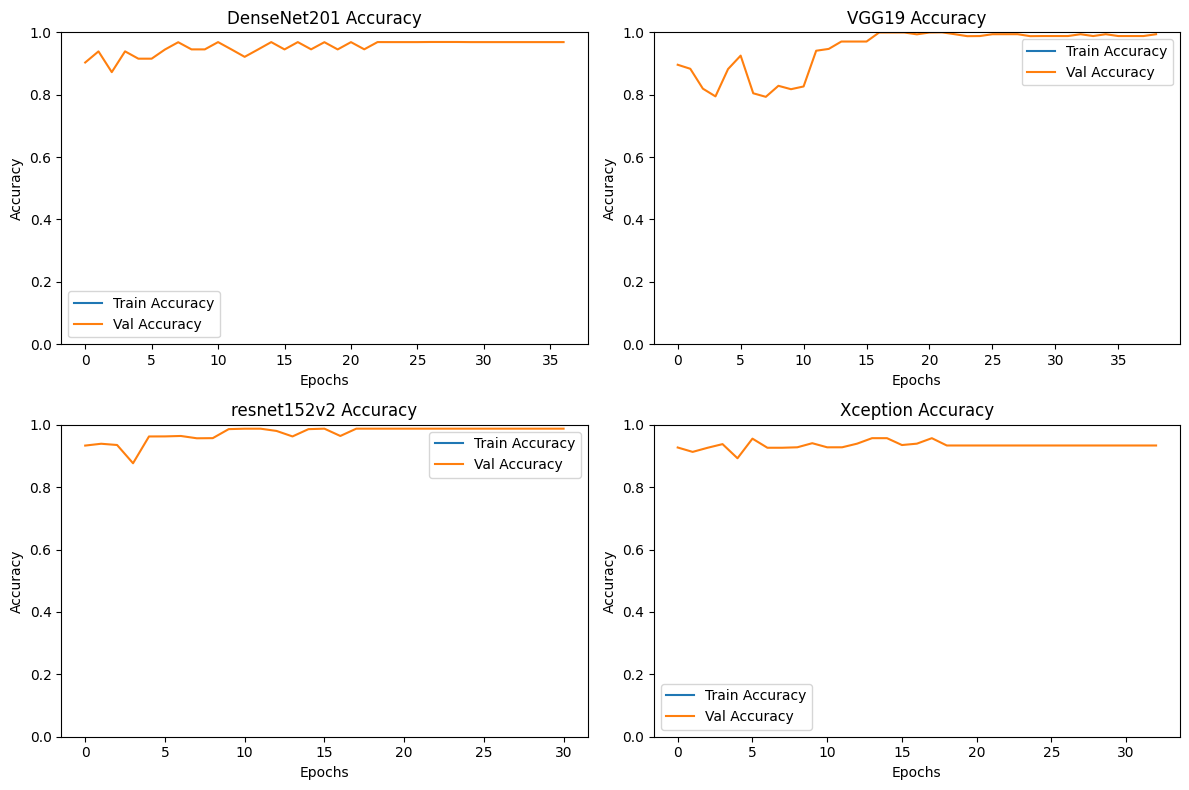

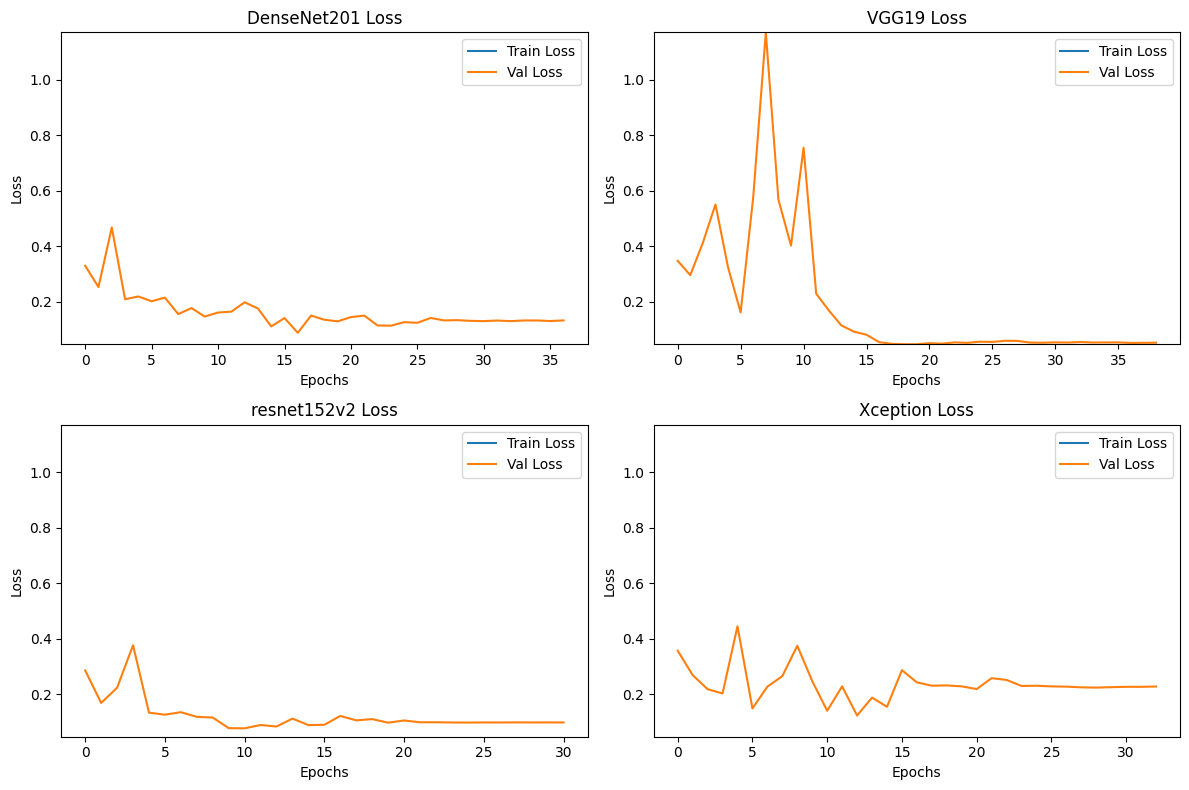

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(histories, model_names):
    # ---- Vẽ biểu đồ Accuracy ----
    # Với accuracy thường nằm trong khoảng [0, 1], nên có thể cố định:
    acc_ylim = (0, 1)
    
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], color='tab:orange', label='Val Accuracy')
        plt.title(f'{model_names[i]} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(acc_ylim)  # Set giới hạn của trục y
        plt.legend()
    plt.tight_layout()
    plt.show()
    
    # ---- Vẽ biểu đồ Loss ----
    # Tính toán giá trị min và max loss trên tất cả các model
    min_loss = float('inf')
    max_loss = float('-inf')
    for history in histories:
        train_loss = np.array(history.history['loss'])
        val_loss = np.array(history.history['val_loss'])
        min_loss = min(min_loss, train_loss.min(), val_loss.min())
        max_loss = max(max_loss, train_loss.max(), val_loss.max())
    
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history['loss'], color='tab:blue', label='Train Loss')
        plt.plot(history.history['val_loss'], color='tab:orange', label='Val Loss')
        plt.title(f'{model_names[i]} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.ylim(min_loss, max_loss)  # Set giới hạn của trục y cho loss
        plt.legend()
    plt.tight_layout()
    plt.show()

# Giả sử bạn đã có các history: history_DenseNet201, history_vgg19, history_resnet152v2, history_xception
histories = [history_DenseNet201, history_vgg19, history_resnet152v2, history_xception]
model_names = ['DenseNet201', 'VGG19', 'resnet152v2', 'Xception']

plot_training_history(histories, model_names)


[Test] y_true shape: (644,) | num_classes = 3
Labels: ['COVID19', 'NORMAL', 'PNEUMONIA']

===== DenseNet201 =====
Classification Report:
              precision    recall  f1-score   support

     COVID19     0.9677    1.0000    0.9836        60
      NORMAL     0.9136    0.9610    0.9367       154
   PNEUMONIA     0.9881    0.9651    0.9765       430

    accuracy                         0.9674       644
   macro avg     0.9565    0.9754    0.9656       644
weighted avg     0.9684    0.9674    0.9676       644



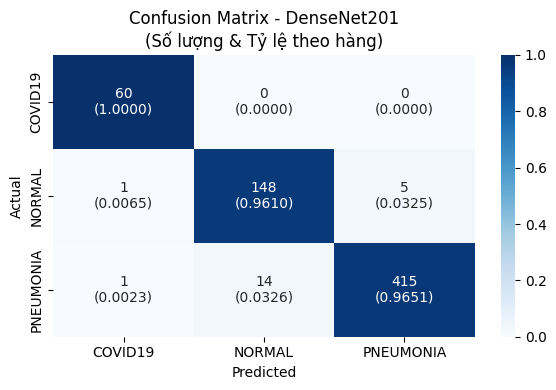


===== VGG19 =====
Classification Report:
              precision    recall  f1-score   support

     COVID19     0.9524    1.0000    0.9756        60
      NORMAL     0.9408    0.9286    0.9346       154
   PNEUMONIA     0.9790    0.9767    0.9779       430

    accuracy                         0.9674       644
   macro avg     0.9574    0.9684    0.9627       644
weighted avg     0.9674    0.9674    0.9673       644



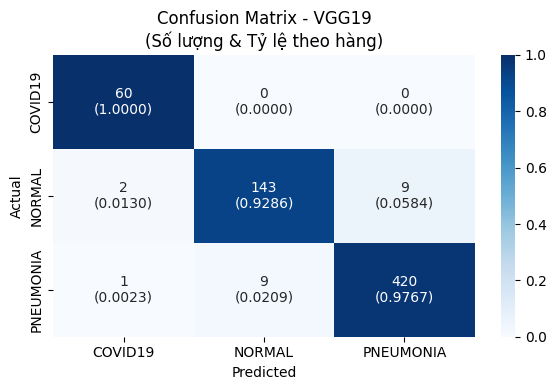


===== ResNet152V2 =====
Classification Report:
              precision    recall  f1-score   support

     COVID19     0.9836    1.0000    0.9917        60
      NORMAL     0.9932    0.9416    0.9667       154
   PNEUMONIA     0.9794    0.9953    0.9873       430

    accuracy                         0.9829       644
   macro avg     0.9854    0.9790    0.9819       644
weighted avg     0.9831    0.9829    0.9828       644



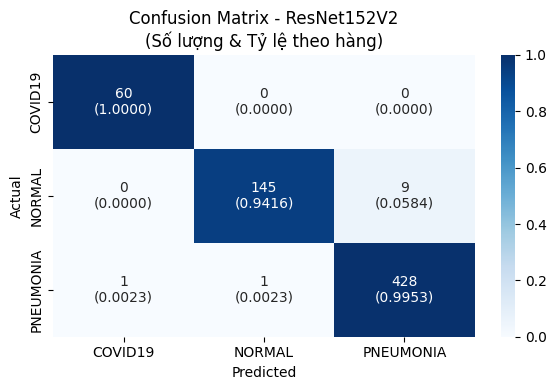


===== Xception =====
Classification Report:
              precision    recall  f1-score   support

     COVID19     0.9677    1.0000    0.9836        60
      NORMAL     0.9658    0.9156    0.9400       154
   PNEUMONIA     0.9748    0.9884    0.9815       430

    accuracy                         0.9720       644
   macro avg     0.9694    0.9680    0.9684       644
weighted avg     0.9720    0.9720    0.9718       644



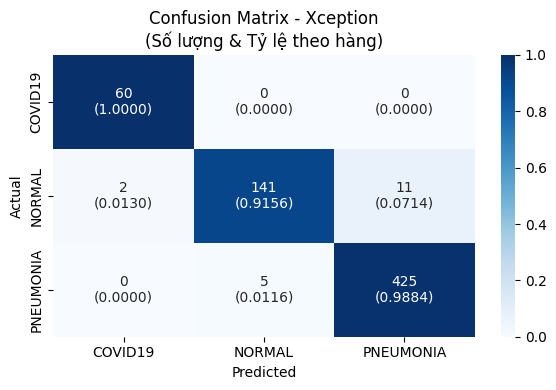


===== Ensemble =====
Classification Report:
              precision    recall  f1-score   support

     COVID19     0.9677    1.0000    0.9836        60
      NORMAL     0.9669    0.9481    0.9574       154
   PNEUMONIA     0.9838    0.9860    0.9849       430

    accuracy                         0.9783       644
   macro avg     0.9728    0.9780    0.9753       644
weighted avg     0.9782    0.9783    0.9782       644



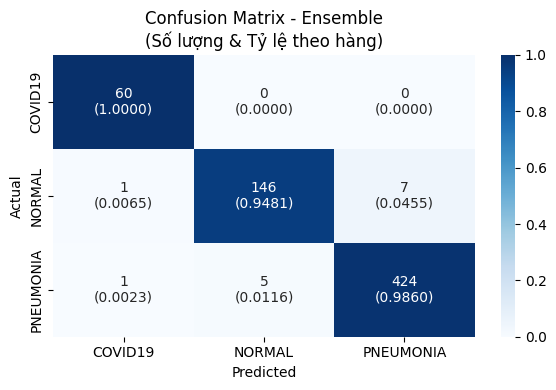

In [25]:
# ==== REPORT & CONFUSION MATRIX (MULTI-CLASS, STYLE GIỐNG NHỊ PHÂN) ====
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# -----------------------------
# 1) Thu thập models khả dụng
# -----------------------------
_model_vars = [
    ("DenseNet201", "DenseNet201_model"),
    ("VGG19",       "vgg19_model"),
    ("ResNet152V2", "resnet152v2_model"),
    ("Xception",    "xception_model"),
    ("Ensemble",    "capsule_ensemble_model"),   # Giữ tên "Ensemble" như yêu cầu
]
models, model_names = [], []
for disp, var in _model_vars:
    m = globals().get(var, None)
    if m is not None:
        models.append(m)
        model_names.append(disp)
if not models:
    raise RuntimeError("Không tìm thấy bất kỳ model nào trong: " + ", ".join(v for _, v in _model_vars))

# -----------------------------
# 2) Helpers cho nhãn & dữ liệu
# -----------------------------
def _to_class_indices(y):
    """Chuyển y về chỉ số lớp [N] cho đa lớp/nhị phân."""
    y = np.asarray(list(y) if isinstance(y, (list, tuple)) else y)
    if y.ndim == 2:
        if y.shape[1] == 1:  # sigmoid
            return (y[:, 0] >= 0.5).astype(int)
        return y.argmax(axis=1).astype(int)
    if y.ndim == 1:
        return y.astype(int)
    raise ValueError(f"Unsupported y shape: {y.shape}")

def _infer_num_classes(y_true, model=None):
    """Suy luận số lớp từ y_true hoặc từ model.output_shape."""
    if y_true.ndim == 2:
        return int(y_true.shape[1])
    if y_true.ndim == 1:
        return int(np.max(y_true)) + 1
    if model is not None and hasattr(model, "output_shape"):
        return int(model.output_shape[-1])
    return 2

def _class_names(num_classes):
    cn = globals().get("class_names", None)
    if isinstance(cn, (list, tuple)) and len(cn) == num_classes:
        return list(map(str, cn))
    return [f"C{i}" for i in range(num_classes)]

def _extract_data_and_labels(Xtest, Ytest=None):
    """Hỗ trợ: numpy, tf.data.Dataset, DirectoryIterator hoặc Sequence"""
    if isinstance(Xtest, np.ndarray):
        if Ytest is None:
            raise ValueError("x_test là numpy, cần truyền y_test.")
        return Xtest, _to_class_indices(Ytest), Xtest

    if isinstance(Xtest, tf.data.Dataset):
        y_list, x_list = [], []
        for batch in Xtest:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                xb, yb = batch
                x_list.append(np.array(xb))
                y_list.append(np.array(yb))
        if y_list:
            X_mat = np.concatenate(x_list, axis=0)
            y_true = _to_class_indices(np.concatenate(y_list, axis=0))
            return Xtest, y_true, X_mat
        if Ytest is None:
            raise ValueError("Dataset không chứa nhãn, cần y_test.")
        return Xtest, _to_class_indices(Ytest), None

    try:
        from tensorflow.keras.preprocessing.image import DirectoryIterator
    except Exception:
        DirectoryIterator = tuple()

    if isinstance(Xtest, DirectoryIterator) or (hasattr(Xtest, "__len__") and hasattr(Xtest, "__getitem__")):
        Xs, Ys = [], []
        for i in range(len(Xtest)):
            xb, yb = Xtest[i]
            if xb is None or (hasattr(xb, "shape") and xb.shape[0] == 0):
                continue
            Xs.append(np.asarray(xb))
            Ys.append(np.asarray(yb))
        X_mat = np.concatenate(Xs, axis=0)
        y_true = _to_class_indices(np.concatenate(Ys, axis=0))
        return Xtest, y_true, X_mat

    if Ytest is None:
        raise ValueError("Không nhận diện được kiểu x_test. Cần y_test.")
    return Xtest, _to_class_indices(Ytest), None

def _predict_labels(model, X_for_pred, materialized_X=None, batch_size=None):
    """Trả về y_pred_indices cho đa lớp (argmax), nhị phân (ngưỡng 0.5)."""
    bs = batch_size or globals().get("BATCH_SIZE", 32)
    try:
        pred = model.predict(X_for_pred, batch_size=bs, verbose=0)
    except Exception:
        pred = model.predict(materialized_X if materialized_X is not None else X_for_pred,
                             batch_size=bs, verbose=0)
    p = np.asarray(pred)
    if p.ndim == 1:
        return (p >= 0.5).astype(int)
    if p.shape[1] == 1:
        return (p[:, 0] >= 0.5).astype(int)
    return p.argmax(axis=1).astype(int)

# -----------------------------
# 3) Lấy test set từ các biến toàn cục
# -----------------------------
X_global  = globals().get("x_test", None)
Y_global  = globals().get("y_test", None)
Dataset_g = globals().get("test_ds", None) or globals().get("test_datagen", None)

if X_global is not None:
    X_source, y_true, X_mat = _extract_data_and_labels(X_global, Y_global)
elif Dataset_g is not None:
    X_source, y_true, X_mat = _extract_data_and_labels(Dataset_g, None)
else:
    raise RuntimeError("Không tìm thấy dữ liệu test: cần x_test/y_test hoặc test_ds/test_datagen.")

num_classes = _infer_num_classes(y_true, model=models[0])
labels = _class_names(num_classes)

print(f"[Test] y_true shape: {y_true.shape} | num_classes = {num_classes}")
print(f"Labels: {labels}")

# -----------------------------
# 4) In báo cáo & Vẽ Confusion
# -----------------------------
for model, name in zip(models, model_names):
    print(f"\n===== {name} =====")
    y_pred_idx = _predict_labels(model, X_source, materialized_X=X_mat)

    # ---- Classification Report (4 decimals) ----
    print("Classification Report:")
    print(classification_report(y_true, y_pred_idx, target_names=labels, digits=4, zero_division=0))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_true, y_pred_idx, labels=list(range(num_classes)))
    row_sums = cm.sum(axis=1, keepdims=True).astype(float)
    row_sums[row_sums == 0] = 1.0
    cm_pct = cm / row_sums

    # Nhãn ô: "count\n(ratio)"
    cell_text = np.array([[f"{cm[i,j]}\n({cm_pct[i,j]:.4f})" for j in range(cm.shape[1])] for i in range(cm.shape[0])])

    # ---- Vẽ Heatmap với style giống nhị phân ----
    plt.figure(figsize=(max(6, 1.2 * num_classes), max(4, 1.0 * num_classes)))
    sns.heatmap(cm_pct,
                annot=cell_text,
                fmt="",
                cmap="Blues",     # <== GIỮ NGUYÊN MÀU NHƯ NHỊ PHÂN
                xticklabels=labels,
                yticklabels=labels,
                cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}\n(Số lượng & Tỷ lệ theo hàng)')
    plt.tight_layout()
    plt.show()


# **Classification report & Confusion matrix**


In [22]:
!tar -czvf working_dir_3label.tar.gz /kaggle/working


tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/DenseNet201_best_model.keras
/kaggle/working/vgg19_best_model.keras
/kaggle/working/capsule_ensemble_best_model.keras
/kaggle/working/xception_best_model.keras
/kaggle/working/resnet152v2_best_model.keras
/kaggle/working/working_dir_3label.tar.gz
tar: /kaggle/working/working_dir_3label.tar.gz: file changed as we read it
/kaggle/working/.virtual_documents/


In [23]:
from IPython.display import FileLink
FileLink("working_dir_3label.tar.gz")


/kaggle/working/working_dir_3label.tar.gz